In [2]:
%matplotlib inline

from bs4 import BeautifulSoup
import urllib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm

import os
import shutil

In [3]:
HOWMANY = 1
MAX_PATCH_SIZE = 64
N_POINTS = 2
DEBUG = True
URL = "https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/index.html"

In [4]:
def generatePointsForOne(image):
    height,width,_ = image.shape
    height -= MAX_PATCH_SIZE/2
    width -= MAX_PATCH_SIZE/2
    ys = np.random.randint(MAX_PATCH_SIZE/2,height,size=(N_POINTS))
    xs = np.random.randint(MAX_PATCH_SIZE/2,width,size=(N_POINTS))
    return [np.dstack((ys,xs))[0]]

def generatePoints(images):
    points = []
    for image in images:
        points += generatePointsForOne(image)
    return np.array(points)

def getRotats(images,points):
    r = []
    ones = np.ones(shape=(N_POINTS, 1))
    
    print("Generating rotated images")
    for a in tqdm([0,1,2,3,5,10,15,30,60,90,180]):
        for img,pp in zip(images,points):
            COLS,ROWS,_ =  img.shape
            M = cv2.getRotationMatrix2D((COLS/2,ROWS/2),a,1)
            rimg = cv2.warpAffine(img,M,(COLS,ROWS))
            rpp = M.dot(np.hstack([pp, ones]).T).T
            r   += [{"img":rimg,"points":rpp}]
    return r
            

def getScales(images,points):
    r = []
    
    print("Generating scaled images")
    for s in tqdm(np.append(np.arange(0.1,1,0.3),np.arange(2,6))):
        for img,pp in zip(images,points):
            rimg = cv2.resize(img,None,fx=s,fy=s)
            rpp = s*pp
            r   += [{"img":rimg,"points":rpp}]
    return r

def getBlures(images,points):
    r = []
    
    print("Generating blureded images")
    for img,pp in zip(images,points):
        r   += [{"img":img,"points":pp}]
    
    for b in tqdm(np.arange(1,10)):
        for img,pp in zip(images,points):
            rimg = cv2.GaussianBlur(img,(5,5),b)
            r   += [{"img":rimg,"points":pp}]
    return r

def getJpgeds(images,points):
    r = []
    dirname = "tmp"
    label = "file{}_{}.jpeg"
    if os.path.isdir(dirname) and DEBUG:
        shutil.rmtree(dirname) 
    os.mkdir(dirname)
    
    print("Generating images compressed using JPEG algorithm")
    for q in tqdm(np.arange(0,101,10)):
        for i,(img,pp) in enumerate(zip(images,points)):
            filename = os.path.join(dirname, label.format(i,q))
            cv2.imwrite(filename, img, [cv2.IMWRITE_JPEG_QUALITY, i])
            rimg = cv2.imread(filename)
            r   += [{"img":rimg,"points":pp}]
    shutil.rmtree(dirname) 
    return r   

def getTransformations(images,points):
    x = {}
    x["rotat"] = getRotats(images,points)
    x["scale"] = getScales(images,points)
    x["blure"] = getBlures(images,points)
    x["jpged"] = getJpgeds(images,points)
    return x

In [5]:
def loadImage(url):
    raw = urllib.request.urlopen(url).read()
    npraw= np.array(bytearray(raw),dtype=np.uint8)
    return cv2.imdecode(npraw,-1)#-1 -> as is (with the alpha channel)

def getImageName(url):
    return url.split('/').pop().split('.').pop(0)

def loadImagesFromSite(url):
    imgs = []
    print("Loading {} image(s) from {}".format(HOWMANY,url))
    with urllib.request.urlopen(url) as response:
        html = BeautifulSoup(response.read(),"lxml")
        for link in tqdm(html.find_all('a')[:HOWMANY]):
            img = loadImage(link.get('href'))
            imgs += [img]
    return np.array(imgs)  

def saveDataset(t):
    for key in ["rotat","scale","blure","jpged"]:
        with open('pickledDataset_{}'.format(key),'wb') as f:
            pickle.dump(t[key],f)
        
def loadDataset():
    try:
        t = {}
        for key in ["rotat","scale","blure","jpged"]:
            with open('pickledDataset_{}'.format(key),'rb') as f:
                t[key] = pickle.load(f)
        return t
    except:
        return None
    
def getDataset():
    t = loadDataset()
    if t is None or DEBUG:
        images = loadImagesFromSite(URL)
        points = generatePoints(images)
        t = getTransformations(images,points)
        
        saveDataset(t)
    return t
    
def display(X,lset,howmany=None):
    if howmany is None:
        howmany = len(X[lset])
    
    print("Preparing images to display")
    for i in tqdm(range(howmany)):
        img = X[lset][i]["img"]
        pp  = X[lset][i]["points"]
        c = (img.max(),img.max(),img.max())
        plt.figure()
        plt.imshow(img)
        
        

Loading 1 image(s) from https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/index.html


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.76s/it]


Generating rotated images


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 68.58it/s]


Generating scaled images


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 42.83it/s]


Generating blureded images


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 130.14it/s]


Generating images compressed using JPEG algorithm


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  8.96it/s]


Preparing images to display


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.66it/s]


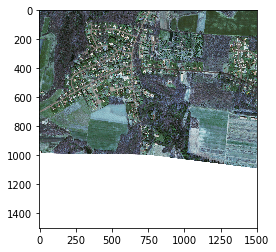

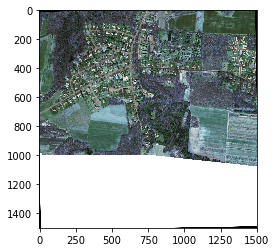

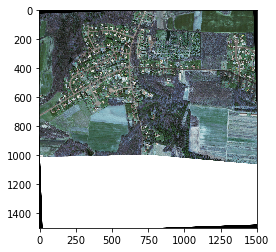

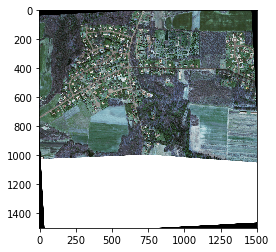

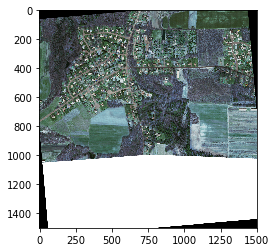

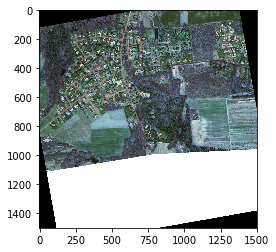

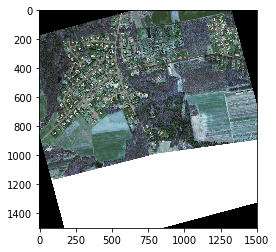

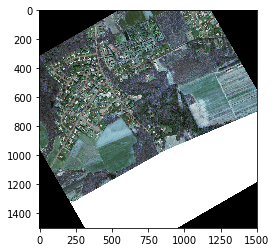

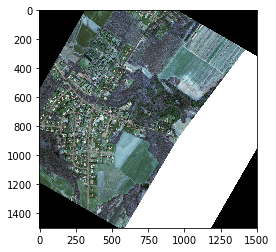

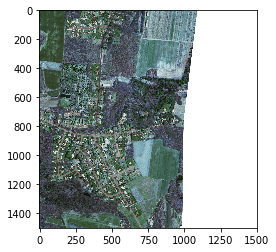

In [6]:
if __name__ =="__main__":
    t = getDataset()
    